<span style="font-size:20px;">**Inisialisasi Library**</span>

In [1]:
#!/usr/bin/env python3
import numpy as np
import tf.transformations as tf
from math import *
import cmath
from geometry_msgs.msg import Pose, Quaternion
from math import radians

#Visual Kinematics Library
from visual_kinematics.RobotSerial import *
from visual_kinematics.RobotTrajectory import *
import numpy as np
from math import pi

<span style="font-size:20px;">**Inisialisasi Parameter Denavit-Hartenberg**</span>
1. D-H Parameter untuk Visual Kinematics Lib
2. D-H Parameter untuk Hitung Manual

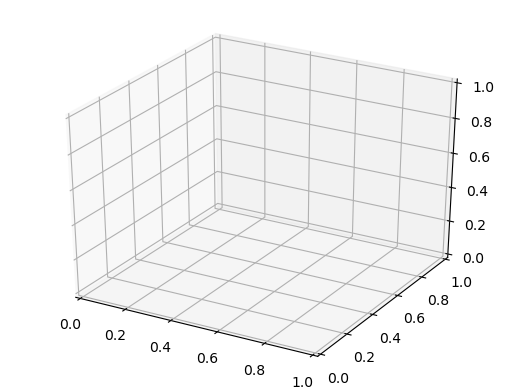

In [4]:
#D-H Parameter untuk Visual Kinematics
dh_params = np.array([  [0.1519,   0.,       pi/2,   0.],
                        [0.,      -0.24365,  0.,     0.],
                        [0.,      -0.21325,  0.,     0.],
                        [0.11235,  0.,       pi/2,   0.],
                        [0.08535,  0.,       -pi/2,  0.],
                        [0.0819,   0.,       0.,     0.]])
robot = RobotSerial(dh_params)

# Inisialisasi Parameter Denavit-Hartenberg (Teoritikal) (Hitung Manual)
# d (unit: meter)
d1 = 0.1519 
d2 = d3 = 0
d4 = 0.11235
d5 = 0.08535
d6 = 0.0819

# a (unit: mm)
a1 = a4 = a5 = a6 = 0
a2 = -0.24365
a3 = -0.21325

# List type of D-H parameter
d = np.array([d1, d2, d3, d4, d5, d6]) # unit: mm
a = np.array([a1, a2, a3, a4, a5, a6]) # unit: mm
alpha = np.array([pi/2, 0, 0, pi/2, -pi/2, 0]) # unit: radian

<span style="font-size:20px;">**Konversi dari UR Format ke ROS Pose Format**</span>
-

In [22]:
# Convert dari UR Format ke ROS Pose Format

def ur2ros(ur_pose):
    """Convert UR format pose to ROS Pose format."""
    ros_pose = Pose()

    # ROS position
    ros_pose.position.x = ur_pose[0]
    ros_pose.position.y = ur_pose[1]
    ros_pose.position.z = ur_pose[2]

    # Orientation in UR format
    rx, ry, rz = ur_pose[3], ur_pose[4], ur_pose[5]

    # Convert orientation from Euler angles to quaternion
    cy = cos(rz * 0.5)
    sy = sin(rz * 0.5)
    cr = cos(rx * 0.5)
    sr = sin(rx * 0.5)
    cp = cos(ry * 0.5)
    sp = sin(ry * 0.5)

    ros_pose.orientation.x = cy * cr * sp - sy * sr * cp
    ros_pose.orientation.y = cy * sr * cp + sy * cr * sp
    ros_pose.orientation.z = sy * cr * cp - cy * sr * sp
    ros_pose.orientation.w = cy * cr * cp + sy * sr * sp
    
    return ros_pose

<span style="font-size:20px;">**Transformasi dari ROS Pose Format ke <span style="color:blue">_np.array_</span> Format**</span>
-

In [6]:
# Transformasi Pose dari ROS Pose format ke np.array format

def ros2np(ros_pose):
    # orientation
    np_pose = tf.quaternion_matrix([ros_pose.orientation.x, ros_pose.orientation.y,
                                    ros_pose.orientation.z, ros_pose.orientation.w])
    
    # position
    np_pose[0][3] = ros_pose.position.x
    np_pose[1][3] = ros_pose.position.y
    np_pose[2][3] = ros_pose.position.z

    return np_pose

<span style="font-size:20px;">**Transformasi dari <span style="color:blue">_np.array_</span> Format ke ROS Pose Format**</span>
-

In [7]:
# Transformasi Pose dari np.array format ke ROS Pose format

def np2ros(np_pose):
    # ROS pose
    ros_pose = Pose()

    # ROS position
    ros_pose.position.x = np_pose[0, 3]
    ros_pose.position.y = np_pose[1, 3]
    ros_pose.position.z = np_pose[2, 3]

    # ROS orientation 
    np_q = tf.quaternion_from_matrix(np_pose)
    ros_pose.orientation.x = np_q[0]
    ros_pose.orientation.y = np_q[1]
    ros_pose.orientation.z = np_q[2]
    ros_pose.orientation.w = np_q[3]

    return ros_pose

<span style="font-size:20px;">**Mencari Solusi Inverse Kinematics Terbaik**</span>
-

In [8]:
#Mencari Solusi Inverse Kinematics Terbaik
def select(q_sols, q_d, w=[1]*6):
    error = []
    for q in q_sols:
        error.append(sum([w[i] * (q[i] - q_d[i]) ** 2 for i in range(6)]))
    
    return q_sols[error.index(min(error))]

<span style="font-size:20px;">**Menghitung Matriks Transformasi Homogen**</span>
-

In [9]:
#Fungsi Matriks Transformasi Homogen
def HTM(i, theta):
    Rot_z = np.matrix(np.identity(4))
    Rot_z[0, 0] = Rot_z[1, 1] = cos(theta[i])
    Rot_z[0, 1] = -sin(theta[i])
    Rot_z[1, 0] = sin(theta[i])

    Trans_z = np.matrix(np.identity(4))
    Trans_z[2, 3] = d[i]

    Trans_x = np.matrix(np.identity(4))
    Trans_x[0, 3] = a[i]

    Rot_x = np.matrix(np.identity(4))
    Rot_x[1, 1] = Rot_x[2, 2] = cos(alpha[i])
    Rot_x[1, 2] = -sin(alpha[i])
    Rot_x[2, 1] = sin(alpha[i])

    A_i = Rot_z * Trans_z * Trans_x * Rot_x	    
    return A_i

<span style="font-size:25px;">**Menghitung Nilai Forward Kinematics**</span>
-

In [10]:
# Forward Kinematics
def fwd_kin(theta, i_unit='r', o_unit='n'):
    T_06 = np.matrix(np.identity(4))

    if i_unit == 'd':
        theta = [radians(i) for i in theta]
    
    for i in range(6):
        T_06 *= HTM(i, theta)

    if o_unit == 'n':
        return T_06
    elif o_unit == 'p':
        return np2ros(T_06)
    else:
        print("Forward Kinematics Result:")
        print(T_06)   

<span style="font-size:25px;">**Menghitung Nilai Inverse Kinematics**</span>
-

In [11]:
def inv_kin(p, q_d, i_unit='r', o_unit='r'):
    # Preprocessing
    if type(p) == Pose: # ROS Pose format
        T_06 = ros2np(p)
    elif type(p) == list: # UR format
        T_06 = ros2np(ur2ros(p))

    if i_unit == 'd':
        q_d = [radians(i) for i in q_d]

    # Initialization of a set of feasible solutions
    theta = np.zeros((8, 6))
    #theta = [[0 for _ in range (6)] for _ in range(8)] 
    for i in range(8):  
        # Inisialisasi nilai-nilai sendi untuk solusi ke-i
        theta[i] = np.zeros(6)

    # theta1
    P_05 = T_06[0:3, 3] - d6 * T_06[0:3, 2]
    phi1 = atan2(P_05[1], P_05[0])
    phi2 = acos(d4 / sqrt(P_05[0] ** 2 + P_05[1] ** 2))
    theta1 = [pi / 2 + phi1 + phi2, pi / 2 + phi1 - phi2]
    theta[0:4, 0] = theta1[0]
    theta[4:8, 0] = theta1[1]
    
    # theta5
    P_06 = T_06[0:3, 3]
    theta5 = []
    for i in range(2):
        theta5.append(acos((P_06[0] * sin(theta1[i]) - P_06[1] * cos(theta1[i]) - d4) / d6))
    for i in range(2):
        theta[2*i, 4] = theta5[0]
        theta[2*i+1, 4] = -theta5[0]
        theta[2*i+4, 4] = theta5[1]
        theta[2*i+5, 4] = -theta5[1]

    # theta6
        # theta6
    T_60 = np.linalg.inv(T_06)
    theta6 = []
    for i in range(2):
        for j in range(2):
            s1 = sin(theta1[i])
            c1 = cos(theta1[i])
            s5 = sin(theta5[j])
            # Handling division by zero
            if s5 != 0:
                theta6.append(atan2((-T_60[1, 0] * s1 + T_60[1, 1] * c1) / s5, (T_60[0, 0] * s1 - T_60[0, 1] * c1) / s5))
            else:
                # Assign a default value or handle this case based on your specific requirement
                theta6.append(0)  # For example, assigning 0 as a default value
    for i in range(2):
        theta[i, 5] = theta6[0]
        theta[i+2, 5] = theta6[1]
        theta[i+4, 5] = theta6[2]
        theta[i+6, 5] = theta6[3]

    # theta3, theta2, theta4
    for i in range(8):  
        # theta3
        T_46 = HTM(4, theta[i]) * HTM(5, theta[i])
        T_14 = np.linalg.inv(HTM(0, theta[i])) * T_06 * np.linalg.inv(T_46)
        P_13 = T_14 * np.array([[0, -d4, 0, 1]]).T - np.array([[0, 0, 0, 1]]).T
        if i in [0, 2, 4, 6]:
            theta[i, 2] = -cmath.acos((np.linalg.norm(P_13) ** 2 - a2 ** 2 - a3 ** 2) / (2 * a2 * a3)).real
            theta[i+1, 2] = -theta[i, 2]
        # theta2
        theta[i, 1] = -atan2(P_13[1], -P_13[0]) + asin(a3 * sin(theta[i, 2]) / np.linalg.norm(P_13))
        # theta4
        T_13 = HTM(1, theta[i]) * HTM(2, theta[i])
        T_34 = np.linalg.inv(T_13) * T_14
        theta[i, 3] = atan2(T_34[1, 0], T_34[0, 0])       

    theta = theta.tolist()

    # Select the most close solution
    q_sol = select(theta, q_d)

    # Output format
    if o_unit == 'r': # (unit: radian)
        return theta
    elif o_unit == 'd': # (unit: degree)
        return [[degrees(angle) for angle in solution] for solution in theta]
    
    print(theta)

<span style="font-size:20px;">**Input untuk Forward Kinematics**</span>

In [12]:
#Input untuk Visual Kinematics
theta_vk = np.array([(5*pi/180), (-57*pi/180), (45*pi/180), (15*pi/180), (5*pi/180), (5*pi/180)])

#Input Forward Kinematics
#joint_values = [radians(25), radians(-64), radians(49), radians(-102), radians(-92), radians(327)]
joint_values = [radians(5), radians(-57), radians(45), radians(15), radians(5), radians(5)]

<span style="font-size:20px;">**Hasil Forward Kinematics**</span>

In [13]:
#Hasil Forward Kinematics Hitung Manual
result = fwd_kin(joint_values, i_unit='r', o_unit='p')  # Menggunakan 'p' untuk output format ROS Pose

print("ROS Pose Forward Kinematics (Hitung Manual):")
print(result)

#Hasil Forward Kinematics Visual Kinematics
f = robot.forward(theta_vk)
robot.end_frame

print()
print("Pose Forward Kinematics Hasil (Visual Kinematics):")
#print("end frame rotational matrix:")
#print(f.r_3_3)
print('ROS Format (Quaternion):')
print("end frame angle-axis(position):")
print(f.r_3)
print("end frame quaternion(orientation):")
print(f.q_4)
print()
#print()
print('UR Format (Euler):')
#print("end frame t_4_4:")
#print(f.t_4_4)
print("end frame xyz (position):")
print(f.t_3_1.reshape([3, ]))
print("end frame abc (rotation):")
print(f.euler_3)
print()

ROS Pose Forward Kinematics (Hitung Manual):
position: 
  x: -0.3257409914003134
  y: -0.223177802741218
  z: 0.31497264420402227
orientation: 
  x: 0.7069990853988242
  y: -0.04932527561613232
  z: 0.049184538196814814
  w: 0.7037756685428851

Pose Forward Kinematics Hasil (Visual Kinematics):
ROS Format (Quaternion):
end frame angle-axis(position):
[ 1.57258186 -0.10971448  0.10940143]
end frame quaternion(orientation):
[ 0.70699909 -0.04932528  0.04918454  0.70377567]

UR Format (Euler):
end frame xyz (position):
[-0.32574099 -0.2231778   0.31497264]
end frame abc (rotation):
[-5.21144235e-04 -1.39425997e-01  1.57540242e+00]



<span style="font-size:20px;">**Input untuk Inverse Kinematics**</span>

In [14]:
#Input Untuk Inverse Kinematics
resultinv = inv_kin(result, joint_values, i_unit='r', o_unit='r')
result_degree = inv_kin(result, joint_values, i_unit='r', o_unit='d')

<span style="font-size:20px;">**8 Solusi Inverse Kinematics dalam Radian**</span>

In [17]:
#Result In Radian
print("Hasil Inverse Kinematics (Hitung Manual):")
print('8 Solusi IK (Radian)')
print("[")
for sublist in resultinv:
    print("[", end=" ")
    for i, value in enumerate(sublist):
        # Print float values with higher precision
        if isinstance(value, float):
            if i == len(sublist) - 1:
                print("{:.15f}".format(value), end=" ")
            else:
                print("{:.15f}".format(value), end=", ")
        else:
            print(value, end=", ")
    print("],")  # Add a closing square bracket and comma for each sublist
print("]")  

Hasil Inverse Kinematics (Hitung Manual):
8 Solusi IK (Radian)
[
[ 0.087266462599716, -0.264545247431471, -0.785398163397463, 1.102303288388765, 0.087266462599701, 0.087266462599715 ],
[ 0.087266462599716, -1.039110298358489, 0.785398163397463, 0.306072012520857, -0.087266462599701, 0.087266462599715 ],
[ 0.087266462599716, -0.264545247431471, -0.785398163397463, 1.102303288388765, 0.087266462599701, 0.087266462599715 ],
[ 0.087266462599716, -1.039110298358489, 0.785398163397463, 0.306072012520857, -0.087266462599701, 0.087266462599715 ],
[ -2.410423243113538, -2.254934255594622, -1.432586234380023, 0.539095900683844, 2.410530633670743, -3.007251374114869 ],
[ -2.410423243113538, -3.441631143590987, 1.432586234380023, -1.139379680079837, -2.410530633670743, -3.007251374114869 ],
[ -2.410423243113538, -2.254934255594622, -1.432586234380023, 0.539095900683844, 2.410530633670743, -3.007251374114869 ],
[ -2.410423243113538, -3.441631143590987, 1.432586234380023, -1.139379680079837, -2.4105

<span style="font-size:20px;">**8 Solusi Inverse Kinematics dalam Degree**</span>

In [19]:
#print("\n")
#Result in Degree
# Result in Degree
print('8 Solusi IK (Derajat)')
print("[")
for sublist in result_degree:
    print("[", end=" ")
    for i, value in enumerate(sublist):
        # Print float values with higher precision
        if isinstance(value, float):
            if i == len(sublist) - 1:
                print("{:.15f}".format(value), end=" ")
            else:
                print("{:.15f}".format(value), end=", ")
        else:
            print(value, end=", ")
    print("],")  # Add a closing square bracket and comma for each sublist
print("]")

# Calculate Cartesian Space from Inverse Kinematics Result
#print("\n")

8 Solusi IK (Derajat)
[
[ 4.999999999999981, -15.157326168067392, -45.000000000000831, 63.157326168068288, 4.999999999999115, 4.999999999999943 ],
[ 4.999999999999981, -59.536634544521199, 45.000000000000831, 17.536634544520414, -4.999999999999115, 4.999999999999943 ],
[ 4.999999999999981, -15.157326168067392, -45.000000000000831, 63.157326168068288, 4.999999999999115, 4.999999999999942 ],
[ 4.999999999999981, -59.536634544521199, 45.000000000000831, 17.536634544520417, -4.999999999999115, 4.999999999999942 ],
[ -138.107078670642096, -129.198215925045901, -82.081145018514675, 30.887919861988028, 138.113231696329535, -172.302811671699374 ],
[ -138.107078670642096, -197.190939168546578, 82.081145018514675, -65.281646931540649, -138.113231696329535, -172.302811671699374 ],
[ -138.107078670642096, -129.198215925045901, -82.081145018514675, 30.887919861988028, 138.113231696329535, -172.302811671699374 ],
[ -138.107078670642096, -197.190939168546578, 82.081145018514675, -65.281646931540649, 

<span style="font-size:20px;">**8 Solusi Inverse Kinematics ROS**</span>

Nilai tersebut merupakan hasil komputasi ulang dari 8 solusi inverse kinematics yang di feedback ulang ke fungsi Forward Kinematics

In [20]:
# Calculate Cartesian Space from Inverse Kinematics Result
print("ROS Pose hasil forward kinematics dari nilai sendi hasil inverse kinematics:")
for index, solution in enumerate(result_degree, start=1):
    result_cartesian = fwd_kin(solution, i_unit='d', o_unit='p')
    print(f"Solution {index}:")
    print(result_cartesian)
    print()

ROS Pose hasil forward kinematics dari nilai sendi hasil inverse kinematics:
Solution 1:
position: 
  x: -0.3257409914003104
  y: -0.22317780274121773
  z: 0.31497264420402243
orientation: 
  x: 0.7069990853988243
  y: -0.049325275616127026
  z: 0.04918453819682021
  w: 0.7037756685428849

Solution 2:
position: 
  x: -0.300241341274103
  y: -0.2209468724312972
  z: 0.33058104917329917
orientation: 
  x: 0.70538430460664
  y: 0.012340714939821399
  z: 0.11075660846054905
  w: 0.7000097593974657

Solution 3:
position: 
  x: -0.3257409914003104
  y: -0.22317780274121773
  z: 0.31497264420402243
orientation: 
  x: 0.7069990853988243
  y: -0.049325275616127026
  z: 0.049184538196820206
  w: 0.7037756685428849

Solution 4:
position: 
  x: -0.300241341274103
  y: -0.2209468724312972
  z: 0.3305810491732991
orientation: 
  x: 0.70538430460664
  y: 0.01234071493982139
  z: 0.11075660846054908
  w: 0.7000097593974657

Solution 5:
position: 
  x: -0.32574099140031354
  y: -0.22317780274121812
  z

<span style="font-size:20px;">**Menampilkan Pose Robot dalam Ruang 3d**</span>

In [ ]:
robot.show()